In [15]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '4309f94a738749dfba52e074aa61851b')

In [ ]:
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
#results = search_images_bing(key, 'red tomato')
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
#hide
ims[0]

'http://all-americaselections.org/wp-content/uploads/2016/09/Tomato_CurrantCandylandRed-AAS2016.PRIMARY-1.jpg'

In [3]:
!ls

01_intro.html		      08_collab.ipynb	      17_foundations.html
01_intro.ipynb		      09_tabular.html	      17_foundations.ipynb
02_production.html	      09_tabular.ipynb	      18_CAM.html
02_production.ipynb	      10_nlp.html	      18_CAM.ipynb
02_production_tomatoes.html   10_nlp.ipynb	      19_learner.html
02_production_tomatoes.ipynb  11_midlevel_data.html   19_learner.ipynb
03_ethics.html		      11_midlevel_data.ipynb  20_conclusion.html
03_ethics.ipynb		      12_nlp_dive.html	      20_conclusion.ipynb
04_mnist_basics.html	      12_nlp_dive.ipynb       __MACOSX
04_mnist_basics.ipynb	      13_convolutions.html    app_blog.html
05_pet_breeds.html	      13_convolutions.ipynb   app_blog.ipynb
05_pet_breeds.ipynb	      14_resnet.html	      app_jupyter.html
06_multicat.html	      14_resnet.ipynb	      app_jupyter.ipynb
06_multicat.ipynb	      15_arch_details.html    tmp
07_sizing_and_tta.html	      15_arch_details.ipynb   tomatoes
07_sizing_and_tta.ipynb       16_accel_sgd.html
08_collab

In [ ]:
destination = 'images/ripe_tomato.jpg'
download_url(ims[0], destination)

In [ ]:
destination

'images/ripe_tomato.jpg'

In [ ]:
!pwd


/Users/oliverwindram/code/fastbook-master/clean


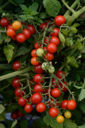

In [ ]:
img = Image.open(destination)
img.to_thumb(128,128)

In [16]:
tomato_types = 'red','green'
path = Path('tomatoes')

In [6]:
!ls './{path}/{tomato_types[0]}'

ls: cannot access './tomatoes/red': No such file or directory


In [18]:
!ls './tomatoes/ripe' | wc -l 

224


In [ ]:
??download_images

In [ ]:
if not path.exists():
    path.mkdir()
    for o in tomato_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} tomato')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
for o in tomato_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} tomato')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [6]:
def rename_file(files_path, prefix):
    with os.scandir(files_path) as it:
        for entry in it:
            file_name = entry.name
            new_name = f'{prefix}{file_name}'
            os.rename(f'{files_path}{file_name}', f'{files_path}{new_name}')

In [7]:
rename_file('tomatoes/ripe/', 'ripe_')
rename_file('tomatoes/unripe/', 'unripe_')

In [4]:
fns = get_image_files(path)
fns

(#511) [Path('tomatoes/ripe/ripe_00000002.jpg'),Path('tomatoes/ripe/ripe_00000003.jpg'),Path('tomatoes/ripe/ripe_00000006.jpg'),Path('tomatoes/ripe/ripe_00000007.jpg'),Path('tomatoes/ripe/ripe_00000008.jpg'),Path('tomatoes/ripe/ripe_00000009.jpg'),Path('tomatoes/ripe/ripe_00000010.jpg'),Path('tomatoes/ripe/ripe_00000011.jpg'),Path('tomatoes/ripe/ripe_00000012.jpg'),Path('tomatoes/ripe/ripe_00000014.jpg')...]

In [5]:
failed = verify_images(fns)
failed

(#0) []

In [11]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [19]:
toms = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [6]:
dls = toms.dataloaders(path)

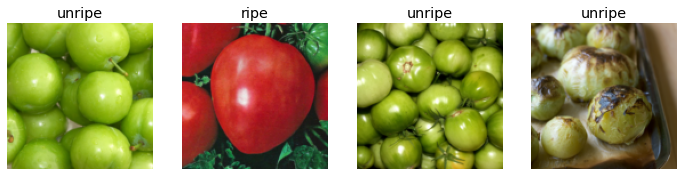

In [7]:
dls.valid.show_batch(max_n=4, nrows=1)

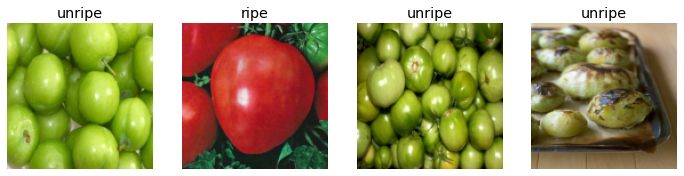

In [8]:
toms = toms.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = toms.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

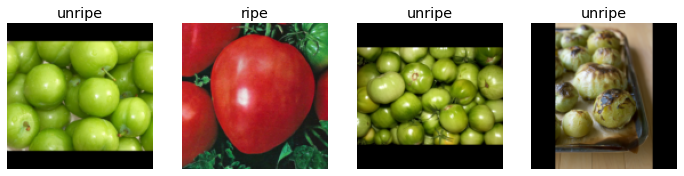

In [9]:
toms = toms.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = toms.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

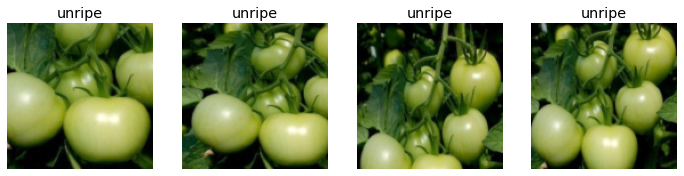

In [10]:
toms = toms.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = toms.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

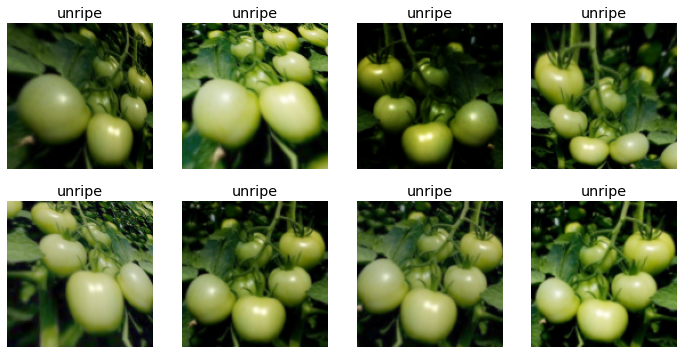

In [11]:
toms = toms.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = toms.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [20]:
toms = toms.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = toms.dataloaders(path)

In [21]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.011816,0.071667,0.011364,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.206115,0.019519,0.000000,00:10
1,0.153568,0.005688,0.000000,00:10
2,0.108969,0.003350,0.000000,00:09
3,0.085471,0.003099,0.000000,00:10


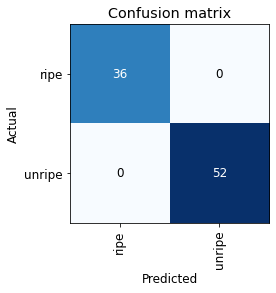

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

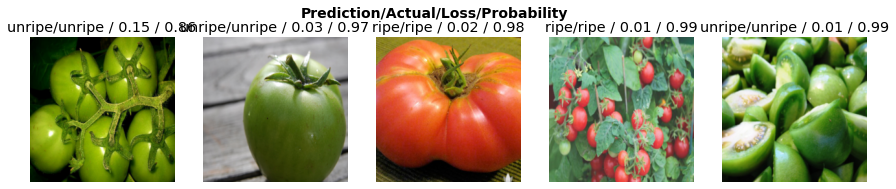

In [23]:
interp.plot_top_losses(5, nrows=1)

In [11]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [13]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [24]:
learn.export()

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
learn_inf = load_learner(path/'export.pkl')

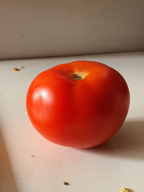

In [29]:
img = PILImage.create('tmp/tendaitom.JPG')
img.to_thumb(192)

In [40]:
img = PILImage.create('tmp/tendaitom.JPG')
pred,pred_idx,probs = learn_inf.predict(img)
print(f"Prediction: this is {pred}.")
print(f"Probability it's {pred}: {probs[pred_idx]:.04f}")

Prediction: this is ripe.
Probability it's ripe: 1.0000


In [27]:
learn_inf.predict('tmp/tendaitom.JPG')

('ripe', TensorImage(0), TensorImage([1.0000e+00, 1.4077e-06]))

In [34]:
learn_inf.dls.vocab

['ripe', 'unripe']

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

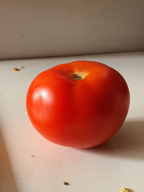

In [37]:
img = PILImage.create('tmp/tendaitom.JPG')
img.to_thumb(192)

In [35]:
pred,pred_idx,probs = learn_inf.predict(img)

In [36]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: ripe; Probability: 1.0000')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 